In [1]:
#IMPORTS

import numpy as np 
import pandas
import math

import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import random
import cv2
from PIL import Image

from skimage import feature
from skimage import color
from skimage import io

from skimage.morphology import binary_closing, disk
from scipy import ndimage as nd

def load_image( path ) :
    img = Image.open( path )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

 
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/My Drive/corn/data/images/20210907_105544.jpg


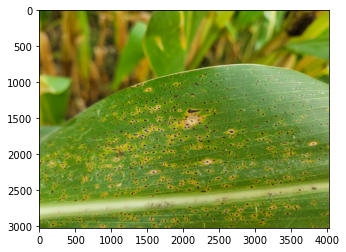

In [25]:
data_root='/content/drive/My Drive/corn/data/images/'
i = 0
for dirpath, _, filenames in os.walk(data_root):
    for filename in filenames:
        i += 1
        if i <= 0:
            continue
        image_path = os.path.join(dirpath, filename)
        raw = load_image(image_path)
        break
    break

print(image_path)
plt.imshow(raw)

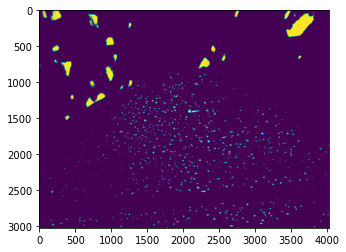

In [26]:
#LESION DETECTION WITH COLOR

# Cast to grayscale; manually using formula used in scipy documentation; had trouble with scipy & cv2
gray = raw[..., :3] @ [0.299, 0.587, 0.114]

# Set threshold level
threshold_level = 60

# Create mask of all pixels lower than threshold level
black_spots = gray < threshold_level

# Color the pixels in the mask
#image[mask] = (200, 119, 0)
#image = np.rot90(image,k=3)

#black_spots = np.rot90(black_spots,k=3)
plt.imshow(black_spots)

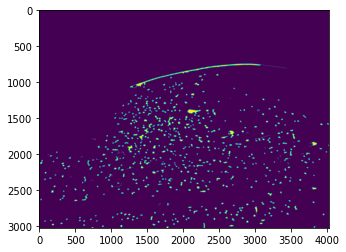

In [27]:
#LESION DETECTION WITH EDGES

#Cast to grayscale
img = color.rgb2gray(raw * 1/256)

#Edge detection
edges = feature.canny(img,sigma=4)

#Close gaps in shapes (C -> O)
bc_disk = disk(11)
edges = binary_closing(edges, bc_disk)

#Fill closed shapes
edges = nd.binary_fill_holes(edges)

plt.imshow(edges)

(3024, 4032)


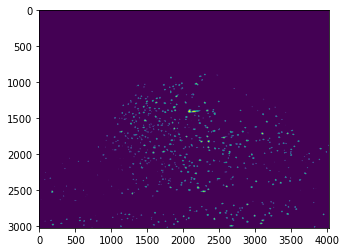

In [28]:
#COMBINE DETECTION METHODS

#Piecewise multiply binary matrices returns pixels both masks agree on
lesion_mask = np.multiply(edges,black_spots)
plt.imshow(lesion_mask)
print(lesion_mask.shape)

In [29]:
def red_box(small_image, big_image):
    #Given classification image and context image, returns copy of context image
    #with a red box around the classification area 
    bw = big_image.shape[1]
    bh = big_image.shape[0]

    sw = small_image.shape[1]
    sh = small_image.shape[0]

    x = int((bw - sw)/2)
    y = int((bh - sh)/2)

    out = np.copy(big_image)

    out[y,x:x+sw,  0]       = 256 #top line
    out[y+sh,x:x+sw+1,  0]    = 256 #bottom line
    out[y:y+sh,x,  0]       = 256 #left line
    out[ y:y+sh,x+sw, 0]    = 256 #right line

    return out

def context_coords(x, 
                   y, 
                   image_dim,
                   classification_shape = (20,20,3),
                   context_shape        = (60,60,3)):

    #40 - 20 - 40
    context_x = int( max(0, x - ( context_shape[0] - classification_shape[0] )/2 ) )
    context_y = int( max(0, y - ( context_shape[1] - classification_shape[1] )/2 ) )

    max_x = image_dim[0] - context_shape[0]
    max_y = image_dim[1] - context_shape[1]

    return min(context_x,max_y),min(context_y,max_y)

In [30]:
#BOUNDS ALL MASKED LESIONS WITH A RECTANGLE
contours, hierarchy = cv2.findContours(lesion_mask.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lesions = []
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    lesions.append((x,y,w,h))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


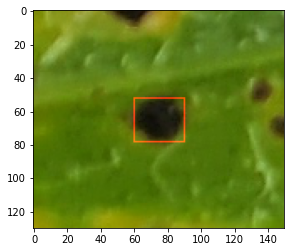

In [61]:
lesion = lesions[random.randint(0,len(lesions))]
x,y,w,h = lesion[0],lesion[1],lesion[2],lesion[3]
tight_bound = raw[y:y+h,x:x+w:]
bound_identity = raw[y-h:y+h+h,x-w:x+w+w,:]
bound_2identity = raw[y-2*h:y+h+2*h,x-2*w:x+w+2*w,:]
boxed = red_box(tight_bound, bound_2identity)
plt.imshow(boxed)
    

#concepts needing labelling: discard, normal, fisheye(brown/green), disk
#disk can prob be inferred by ratio of width to height of bounding rectangle
# 0

#000 : discard
#100 : normal
#110 : eye / brown
#101 : eye / green
#111 : disk?
